<h1>Tarea Semanal 8 - Teoria de circuitos 2</h1>

<h2> Practica de filtrado digital</h2>

<u>Consignas</u>

Parte I - Diseño

Se necesita eliminar las interferencias de una señal electrocardiográfica (ECG) que fue registrada a una frecuencia de muestreo de 1 kHz. Para ello se propone la siguiente plantilla de diseño:

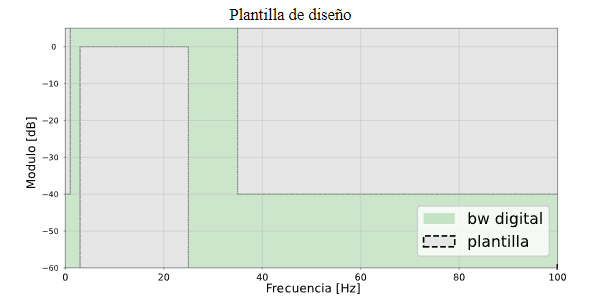

y se pide diseñar dos filtros: uno IIR y otro FIR que cumplan con la plantilla, utilizando alguno de los métodos estudiados. Mostrar la respuesta en frecuencia, para ambos filtros, de:

- módulo
- fase
- retardo
- repuesta al impulso

Parte II - Implementación y uso

En esta parte utilizaremos los dos filtros diseñados para mitigar las interferencias. Para ello se dispone de un notebook de referencia para facilitar la experimentación.




In [1]:

# Módulos importantantes
import scipy.signal as sig
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
from pytc2.sistemas_lineales import plot_plantilla

fs = 1000 # Hz
nyq_frec = fs / 2

# Plantilla

# filter design
ripple = 0.5 # dB
atenuacion = 40 # dB

ws1 = 1.0 #Hz
wp1 = 3 #Hz
wp2 = 25.0 #Hz
ws2 = 35.0 #Hz

frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
gains = 10**(gains/20)


<h3>Parte I</h3>

A continuacion se diseña el filtro pedido por la plantilla para el caso FIR:
En este caso el diseño se hace mediante el metodo de ventanas. Existen multiples tipos de ventana por donde algunas seran optimas para determinadas aplicaciones. En este caso se hara un analisis con todas para determinar la mas eficienciente.


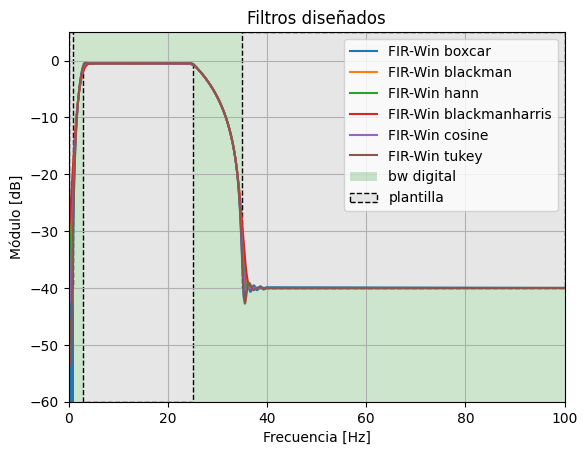

In [2]:
cant_coeficientes = 1501

windows = ["boxcar","blackman","hann","blackmanharris","cosine","tukey"]

den = 1.0

# muestreo el filtro donde me interesa verlo según la plantilla.


for this_window in windows:
    w  = np.append(np.logspace(-1, 0.8, 2500), np.logspace(0.9, 1.6, 2500) )
    w  = np.append(w, np.linspace(110, nyq_frec, 100, endpoint=True) ) / nyq_frec * np.pi
    num_win = sig.firwin2(cant_coeficientes, frecs, gains , window=this_window)
    w, hh_win = sig.freqz(num_win, den, w)
    # renormalizo el eje de frecuencia
    w = w / np.pi * nyq_frec
    plt.plot(w, 20 * np.log10(abs(hh_win)), label=f'FIR-Win {this_window}')



plt.title('Filtros diseñados')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 100, -60, 5 ]);

axes_hdl = plt.gca()
axes_hdl.legend()

plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs)


De este analisis se puede ver que las ventanas "tukey" y "boxcar" nos permiten tener una atenuacion mas rapida, sin embargo tienen un riple en la banda de stop. Se consideran unas buenas opciones para esta aplicacion las ventanas "cosine" y "hann".

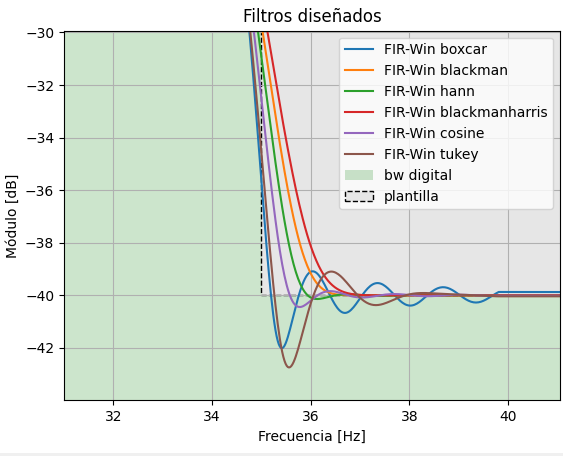

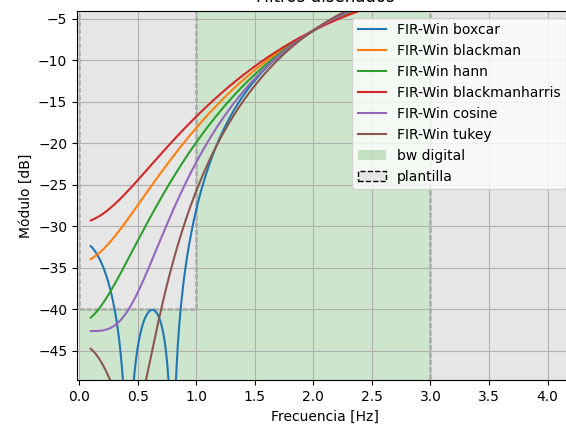



En cuanto a los coeficientes se nota que para un numero bajo no se consigue cumplir con la plantilla. Aumentandolos por encima de los 2000 vemos buenos resultados pero no se consigue cumplir por completo la plantilla. 
Debemos pasar por encima de los 10000 para conseguir una plantilla que cumpla a la perfeccion.

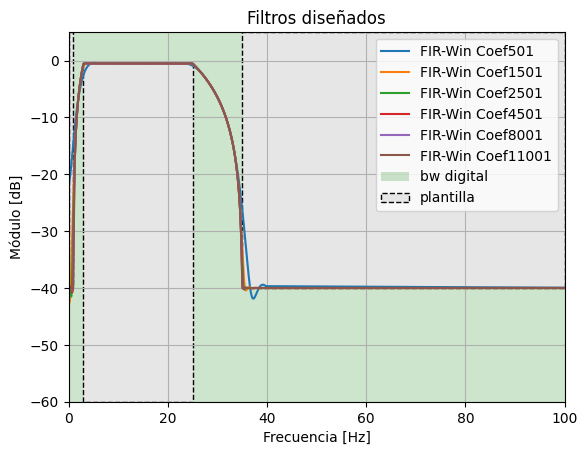

In [3]:

cant_coeficientes = [501,1501,2501,4501,8001,11001]

den = 1.0

# muestreo el filtro donde me interesa verlo según la plantilla.


for this_coef in cant_coeficientes:
    w  = np.append(np.logspace(-1, 0.8, 2500), np.logspace(0.9, 1.6, 2500) )
    w  = np.append(w, np.linspace(110, nyq_frec, 100, endpoint=True) ) / nyq_frec * np.pi
    num_win = sig.firwin2(this_coef, frecs, gains , window="cosine")
    w, hh_win = sig.freqz(num_win, den, w)
    # renormalizo el eje de frecuencia
    w = w / np.pi * nyq_frec
    plt.plot(w, 20 * np.log10(abs(hh_win)), label=f'FIR-Win Coef{this_coef}')



plt.title('Filtros diseñados')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 100, -60, 5 ]);

axes_hdl = plt.gca()
axes_hdl.legend()

plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs)


Si analizamos en mas detalle vemos que por encima de los 4500 taps el filtro se puede aproximar a una plantilla ideal.

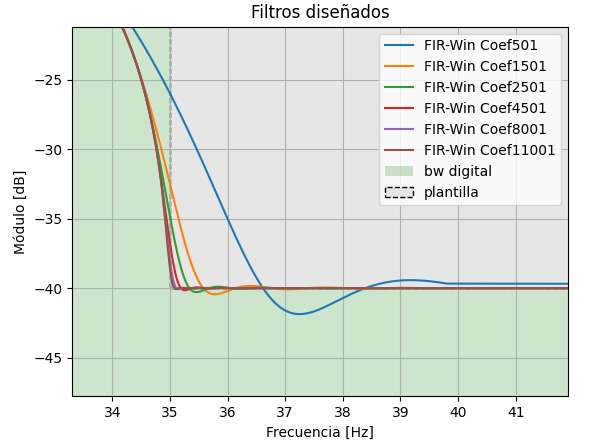

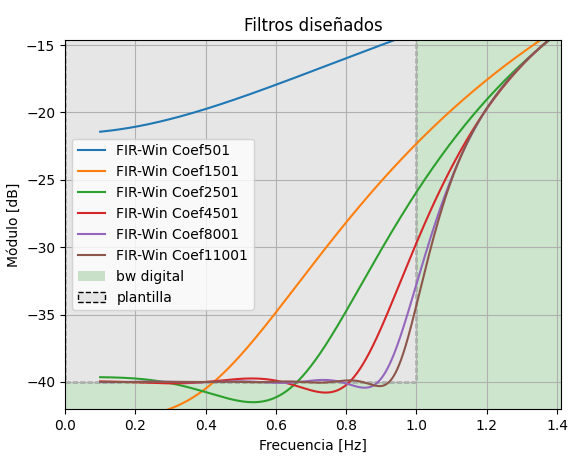

Tomando entonces el filtro FIR con ventana del tipo "cosine" y 8001 taps obtenemos el siguiente sistema


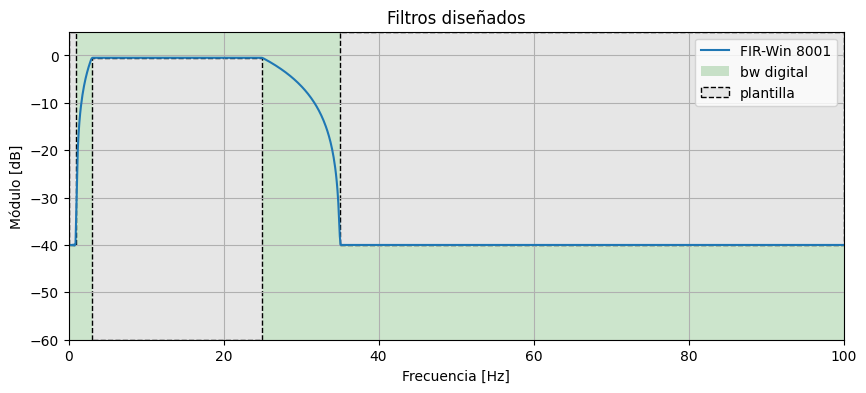

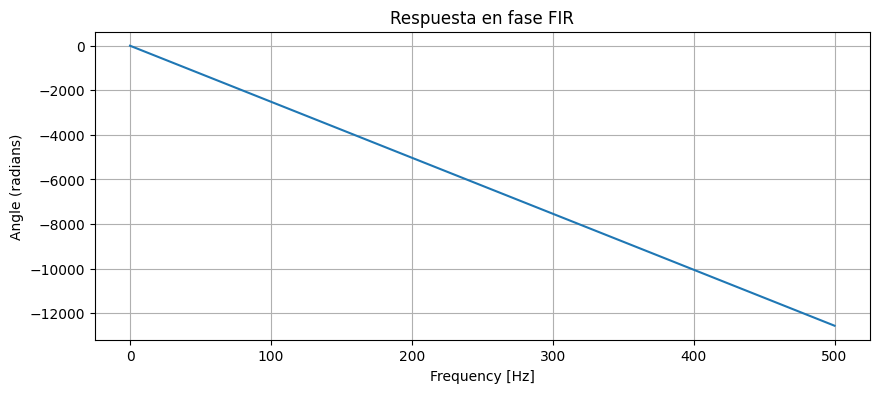

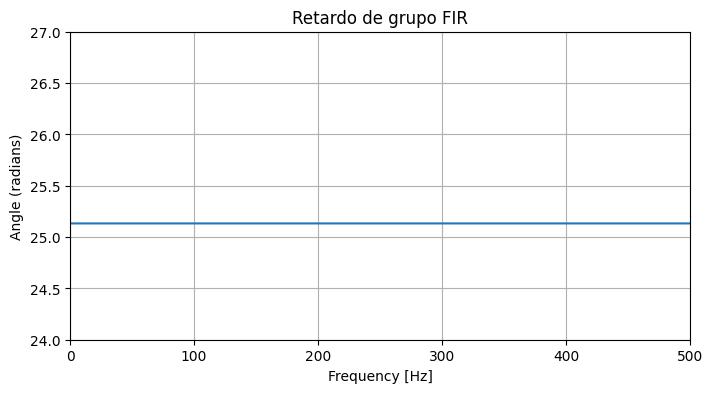

In [67]:
cant_coeficientes = 8001

num_win = sig.firwin2(cant_coeficientes, frecs, gains , window='cosine')

den = 1.0

w = np.linspace(0,np.pi,5000)

w, hh_win = sig.freqz(num_win, den, w)

# renormalizo el eje de frecuencia
w = w / np.pi * nyq_frec

plt.figure(figsize=(10, 4)) 

plt.plot(w, 20 * np.log10(abs(hh_win)), label='FIR-Win {:d}'.format(num_win.shape[0]))

plt.title('Filtros diseñados')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 100, -60, 5 ]);
plt.legend()

plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs)

plt.show()


#Ploteo la fase
plt.figure(figsize=(10, 4))  

plt.title('Respuesta en fase FIR')
angles = np.unwrap(np.angle(hh_win))
plt.plot(w, angles)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Angle (radians)')
plt.grid(True)

plt.show()


plt.figure(figsize=(8, 4))  # Ancho: 8 pulgadas, Alto: 4 pulgadas

plt.title('Retardo de grupo FIR')
group_delay = -np.diff(angles) / np.diff(w)
plt.plot(w[:-1], group_delay)

plt.xlabel('Frequency [Hz]')
plt.ylabel('Angle (radians)')
plt.grid(True)
plt.axis([0, 500, 24,27 ]);
plt.show()


Se puede observar que en este caso la fase y retardo de grupo son lineales. Esto se debe a que los filtros FIR al ser simetricos consiguen una fase lineal y en consecuencia el retardo de grupo es constante. Sin embargo vemos que al ser de numero impar tenemos un retardo de grupo no entero, lo cual es algo no deseado.

Se verifica en este caso que al ser un filtro pasa bandas es necesario tener un numero de coeficientes impar, ya que como se muestra a continuacion tener un numero de coeficientes par implica tener cero dB en nyquist y para el caso nuestro necesitamos atenuar en esa frecuencia.
El ver los coeficientes del filtro tambien se puede observar que son de simetria par, lo cual es mejor ya que se asegura de tener un retardo de grupo entero.

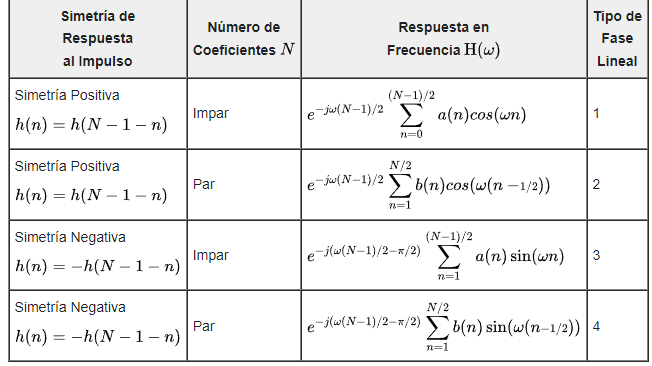

Ahora analizaremos la respuesta al impulso del sistema, para ello crearemos una señal con forma de impulso y se la aplicaremos a nuestro filtro. Lo que esperamos obtener a la salida es una señal que al aplicarle la FFT sea la respuesta del filtro.


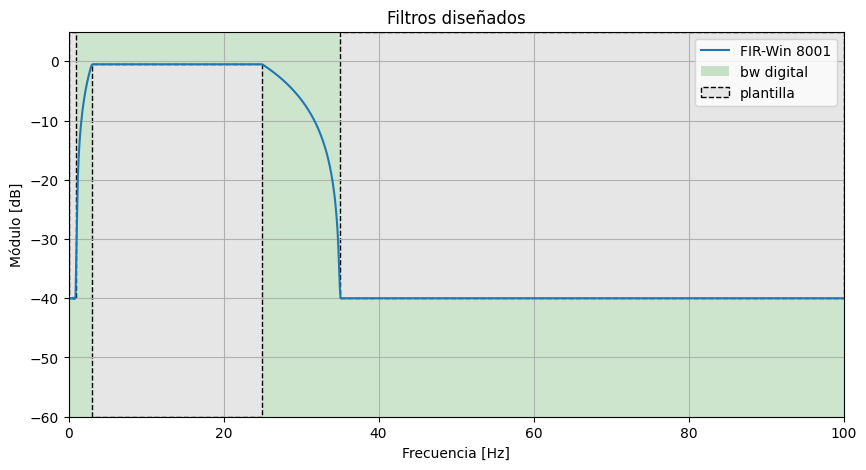

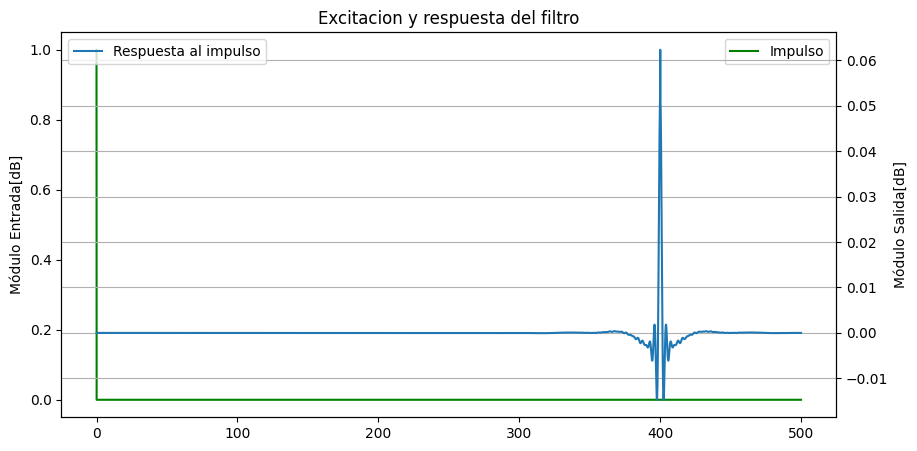

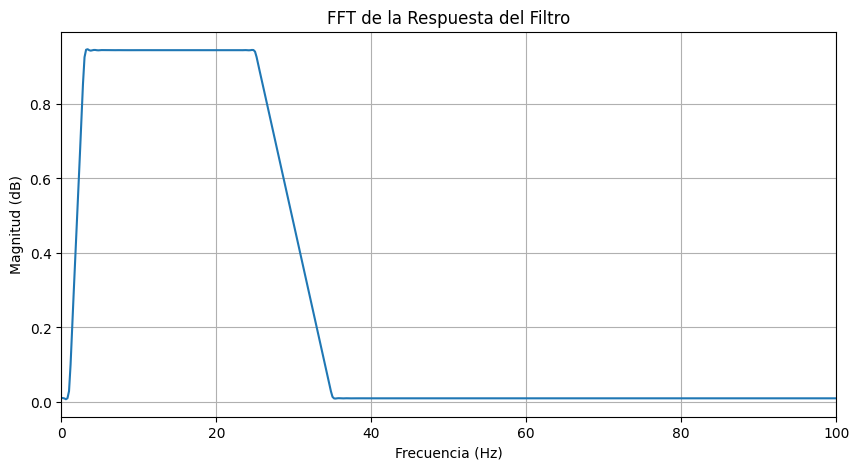

In [68]:
plt.figure(figsize=(10, 5))
plt.plot(w, 20 * np.log10(abs(hh_win)), label='FIR-Win {:d}'.format(num_win.shape[0]))

plt.title('Filtros diseñados')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 100, -60, 5 ]);
plt.legend()
plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs)

plt.show()

plt.figure(figsize=(10, 5))
# FIR
impulse = np.zeros_like(w)
impulse[0] = 1 

respuesta = sig.lfilter(num_win, den,impulse )

plt.title('Excitacion y respuesta del filtro')

plt.plot(w, impulse, label='Impulso',color = "green")
plt.ylabel('Módulo Entrada[dB]')
plt.legend()

plt.twinx()

plt.plot(w, respuesta, label='Respuesta al impulso')
plt.ylabel('Módulo Salida[dB]')
plt.xlabel('Frecuencia [Hz]')

plt.grid()
plt.legend()

plt.show()

# Aplicar la FFT a la señal de respuesta
fft_result = np.fft.fft(respuesta)

# Calcular la frecuencia correspondiente a cada punto de la FFT

frequencies = np.fft.fftfreq(len(fft_result), 1/fs)


half_size = len(fft_result) // 2
fft_result_half = fft_result[:half_size]
frequencies_half = frequencies[:half_size]
magnitude_db = (np.abs(fft_result_half))

# Graficar la magnitud en dB
plt.figure(figsize=(10, 5))
plt.plot(frequencies_half, magnitude_db)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud (dB)')
plt.title('FFT de la Respuesta del Filtro')
plt.grid(True)
plt.xlim(0,100)
plt.show()



<h2>Diseño filtro IIR</h2>

A continuacion se diseña el filtro IIR junto con su respectiva plantilla.

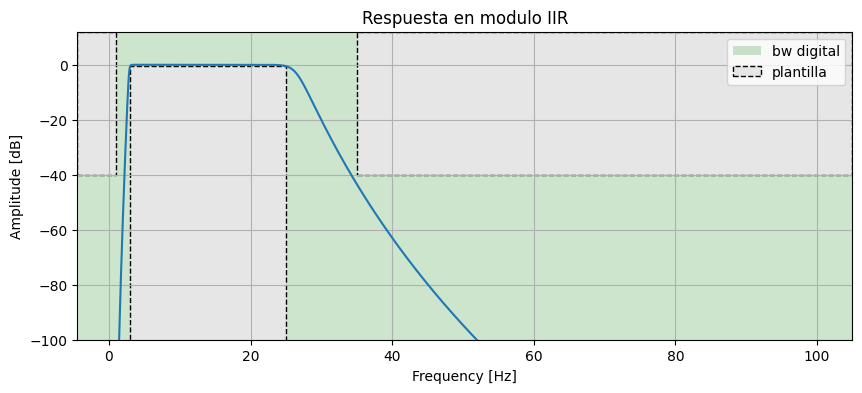

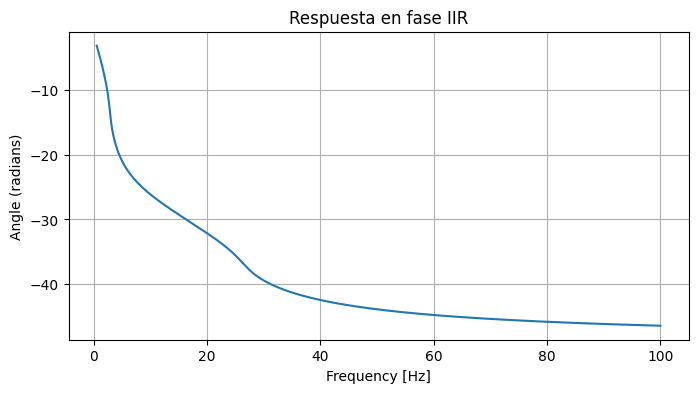

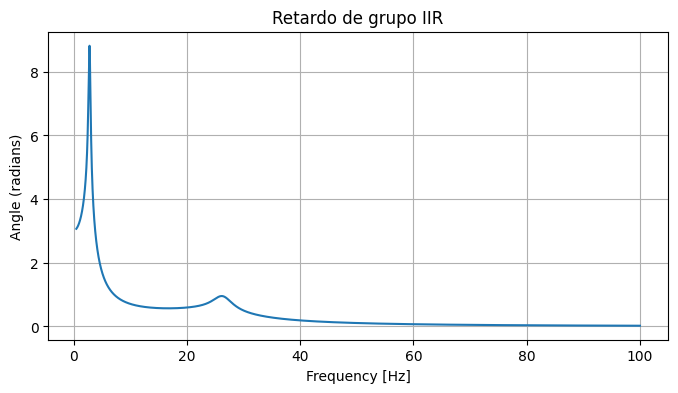

In [69]:
bp_sos_butter = sig.iirdesign(wp = [wp1/nyq_frec, wp2/nyq_frec], ws = [ws1/nyq_frec, ws2/nyq_frec], gpass = 0.5, gstop = 40, analog=False, ftype='butter', output='sos')      

frecuencias = np.linspace(0.5, 100, num = 10000)

w, h = sig.sosfreqz(bp_sos_butter, frecuencias, fs = fs)

# Ploteo el modulo

plt.figure(figsize=(10, 4))  

plt.title('Respuesta en modulo IIR')
plt.plot(w, 20 * np.log10(np.abs(h)))
plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency [Hz]')
plt.grid()

#ploteo la plantilla
plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs)

plt.show()


#Ploteo la fase
plt.figure(figsize=(8, 4)) 

plt.title('Respuesta en fase IIR')
angles = np.unwrap(np.angle(h))
plt.plot(w, angles)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Angle (radians)')
plt.grid(True)

plt.show()


plt.figure(figsize=(8, 4))

plt.title('Retardo de grupo IIR')
group_delay = -np.diff(angles) / np.diff(w)
plt.plot(w[:-1], group_delay)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Angle (radians)')
plt.grid(True)

plt.show()


Como notable podemos ver que la fase en los filtro IIR no es constante y en consecuencia el retardo de grupo tampoco lo es. Esto es una clara desventaja respecto a los filtro FIR que si tienen retardo de grupo constante.

A continuacion se analiza la respuesta al impulso del sistema.


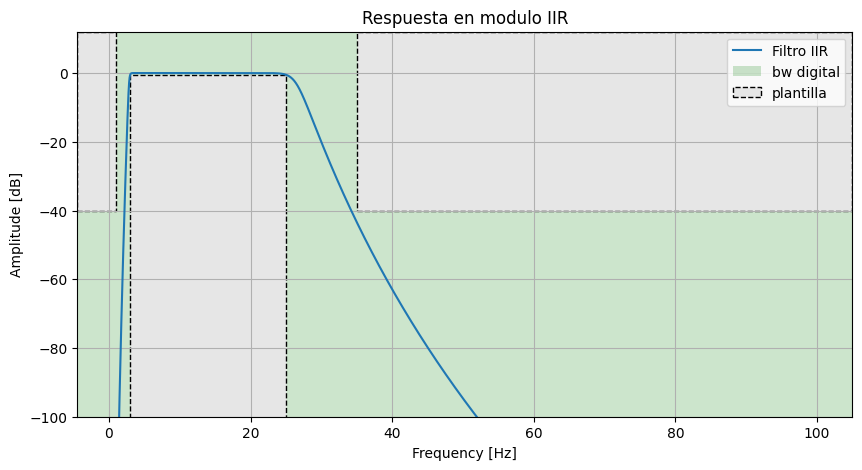

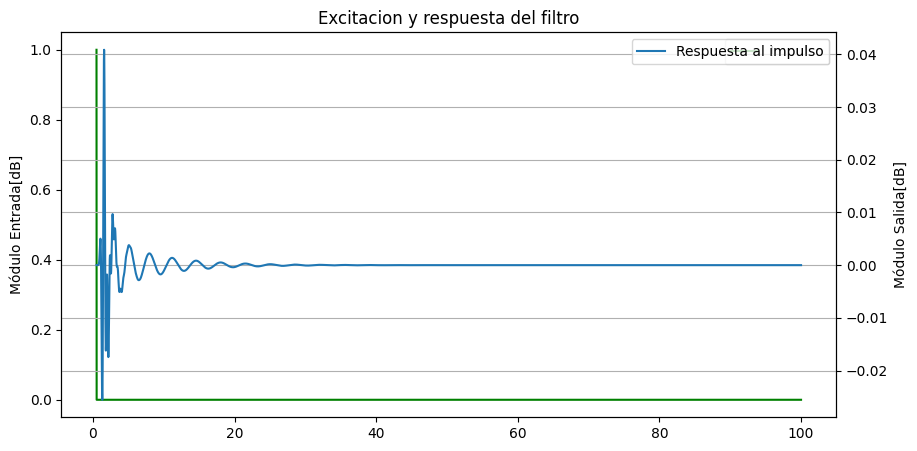

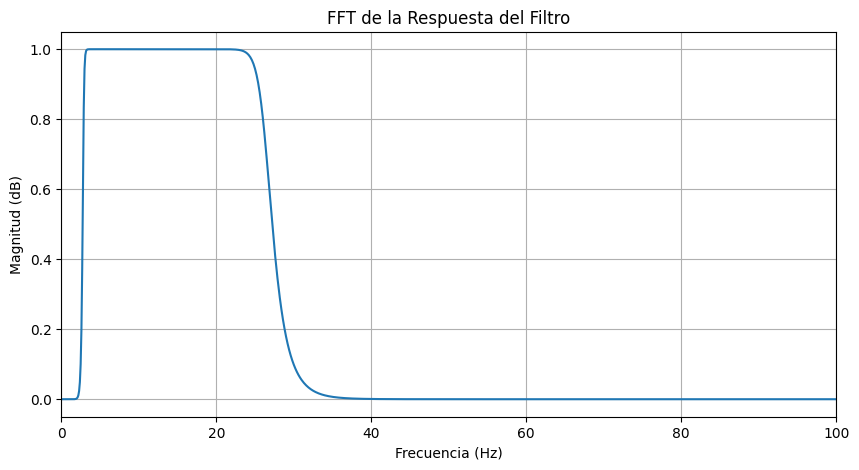

In [72]:
plt.figure(figsize=(10, 5))

plt.title('Respuesta en modulo IIR')
plt.plot(w, 20 * np.log10(np.abs(h)),label = "Filtro IIR")
plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency [Hz]')
plt.grid()
plt.legend()
plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs)

plt.show()

plt.figure(figsize=(10, 5))
# FIR
impulse = np.zeros_like(w)
impulse[0] = 1 

respuesta = sig.sosfilt(bp_sos_butter, impulse)

plt.title('Excitacion y respuesta del filtro')

plt.plot(w, impulse, label='Impulso',color = "green")
plt.ylabel('Módulo Entrada[dB]')
plt.legend()

plt.twinx()

plt.plot(w, respuesta, label='Respuesta al impulso')
plt.ylabel('Módulo Salida[dB]')
plt.xlabel('Frecuencia [Hz]')

plt.grid()
plt.legend()

plt.show()

# Aplicar la FFT a la señal de respuesta
fft_result = np.fft.fft(respuesta)

# Calcular la frecuencia correspondiente a cada punto de la FFT

frequencies = np.fft.fftfreq(len(fft_result), 1/fs)


half_size = len(fft_result) // 2
fft_result_half = fft_result[:half_size]
frequencies_half = frequencies[:half_size]
magnitude_db = (np.abs(fft_result_half))

# Graficar la magnitud en dB
plt.figure(figsize=(10, 5))
plt.plot(frequencies_half, magnitude_db)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud (dB)')
plt.title('FFT de la Respuesta del Filtro')
plt.grid(True)
plt.xlim(0,100)
plt.show()


<h2>Parte II</h2>

Utilizando los filtros diseñados para una señal ECG


In [142]:
#Cargo datos del ECG

mat_struct = sio.loadmat('ecg.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten()
cant_muestras = len(ecg_one_lead)

demora = 550
regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

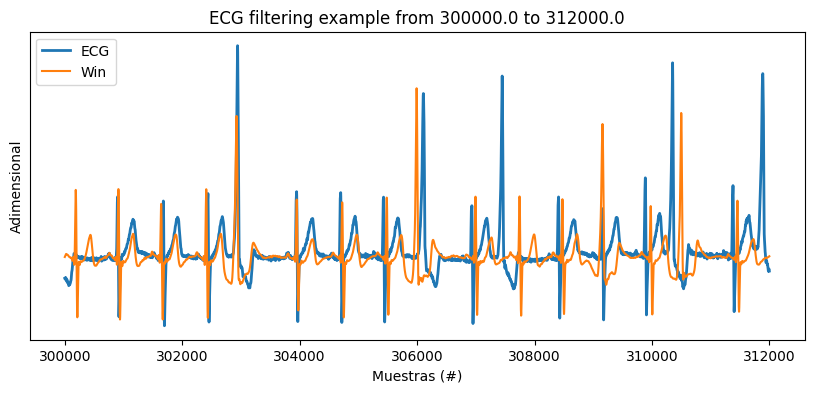

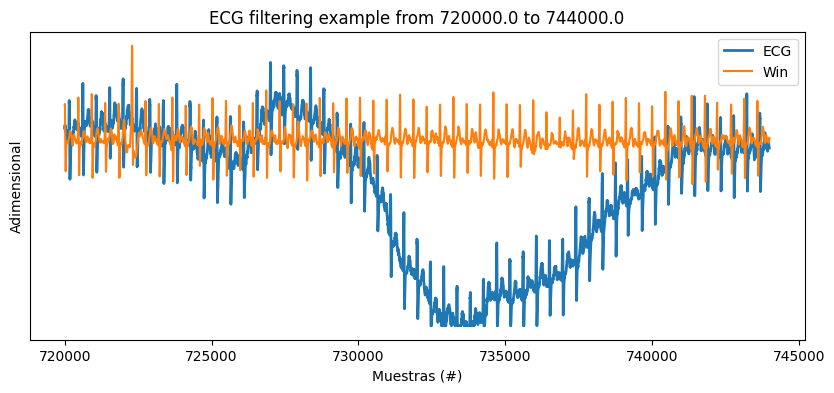

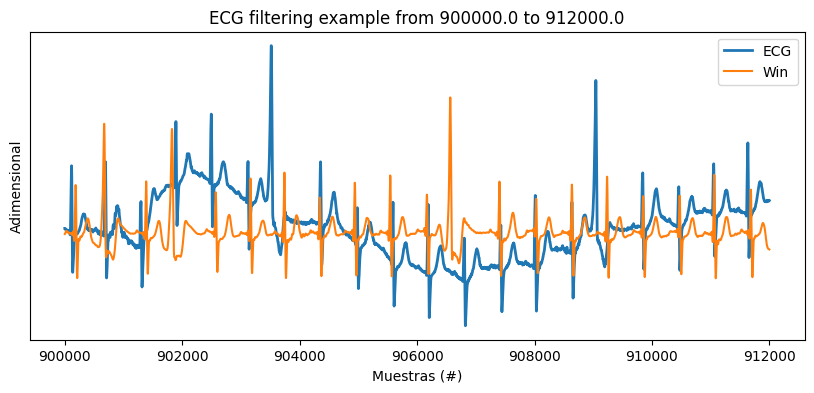

In [120]:

# FIR
ECG_f_win = sig.lfilter(num_win, den, ecg_one_lead)

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(10, 4), facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

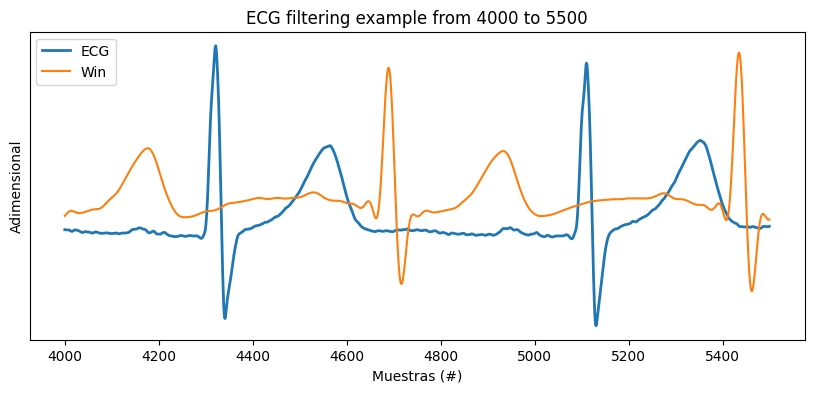

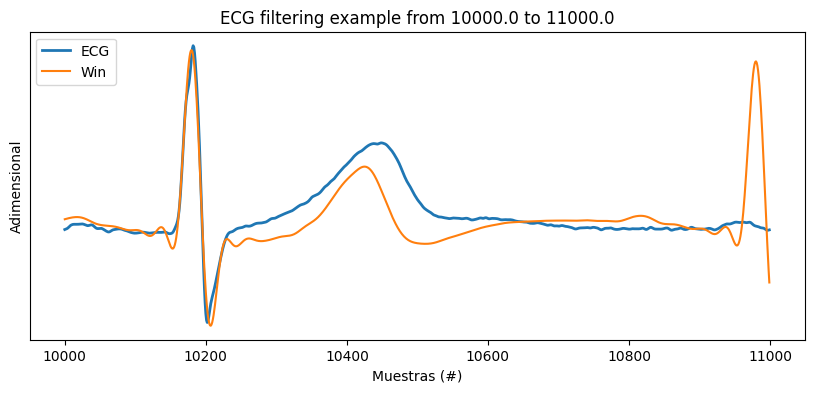

In [143]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(10, 4), facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()
    

A continuacion se aplicara el filtro IIR, en donde se utilizara una tecnica de filtrado bidireccional que elimina culquier distorcion por el retardo de grupo.


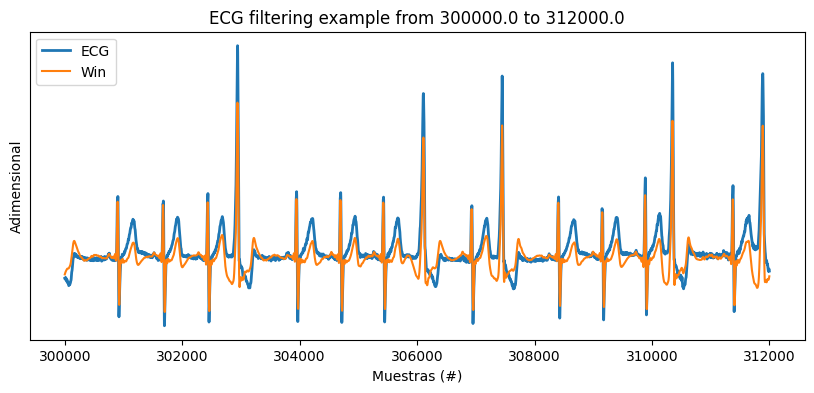

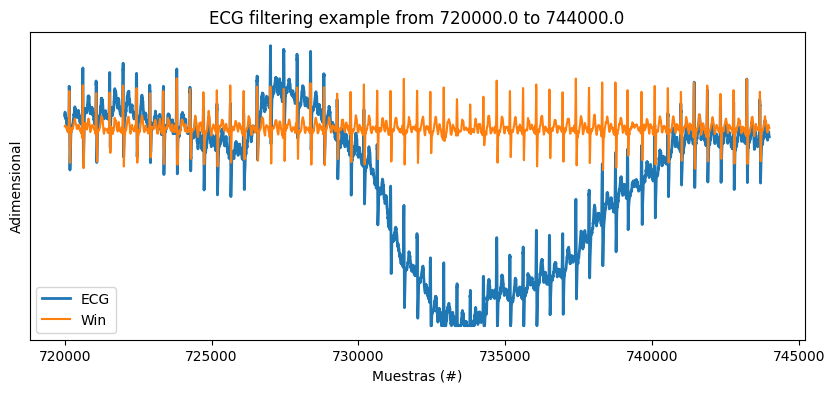

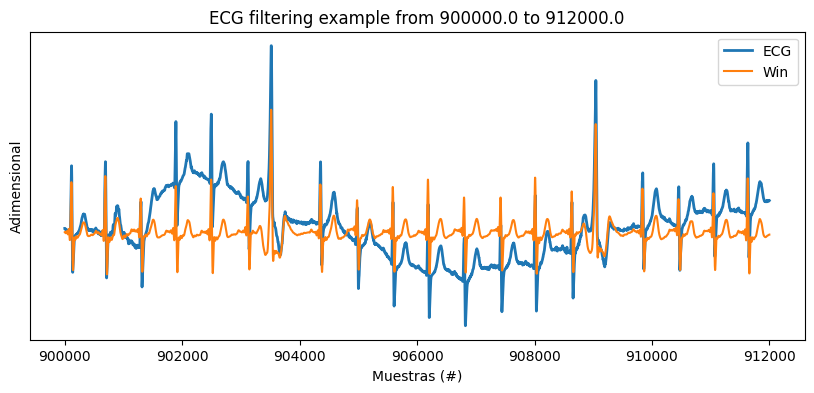

In [148]:
# Procedemos al filtrado
# ECG_f_butt = sig.sosfiltfilt(bp_sos_butter, ecg_one_lead)

ECG_f_win = sig.filtfilt(num_win, den, ecg_one_lead)

# Segmentos de interés
regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(10, 4), facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', lw=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

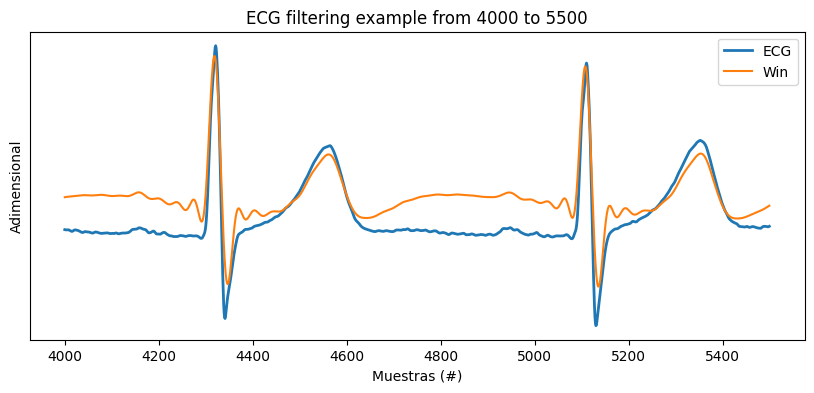

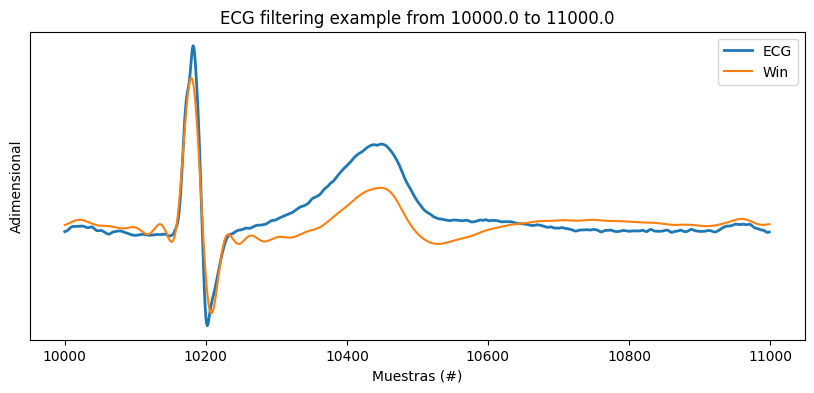

In [151]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(10, 4), facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', lw=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

¿Qué pudo haber causado que los filtros no hayan sido eficientes para eliminar las interferencias?
¿Qué pudo haber causado que los filtros no hayan sido inocuos respecto a las señales NO contaminadas?
Los filtros fueron eficientes eliminando las interferencias sin embargo puede que parte de la interferencia tambien se encuentre en el espectro de la banda de paso, estas interferencias no pueden ser eliminadas por este metodo ya que que no puede dicernir entre lo que es informacion valida y lo que es ruido/interferencia.
Por otro lado, puede ocurrir que la informacion de la señal de interes tambien se encuentre en el espectro filtrado, por lo que se esta perdiendo informacion que no se debia eliminar.

Puede que este metodo no sea el mas adecuado ya que se necesita tener una informacion concordante con la señal de adquirida. Alterarla significa perder datos (o agregar) que eran necesarios para poder analizar a la persona.

Se deberia buscar alguna otra plantilla que permita una mejor representacion de la señal o un metodo distinto. 
Por otro lado seria recomendable reducir las señales de ruido que se adquieren para no depender tanto del filtrado.
